In [ ]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

import io
import PIL.Image, PIL.ImageDraw

import requests

!pip install einops
import einops
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

# Install and import equivariant library
!pip install e2cnn
import e2cnn
from e2cnn import gspaces

# Notebook dependencies
from IPython.display import clear_output, Image

from utils import *

import importlib
import sys

# importlib.reload(sys.modules['utils'])
# from utils import *

device_id = 0
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
device is cuda:0


In [ ]:
# Parameters

CHANNEL_N = 16
TARGET_PADDING = 16
BATCH_SIZE = 8
CELL_FIRE_RATE = 0.5

# TARGET_EMOJI = "🛩"
TARGET_EMOJI = "🦎"

# Load target image
target_img = load_emoji(TARGET_EMOJI)

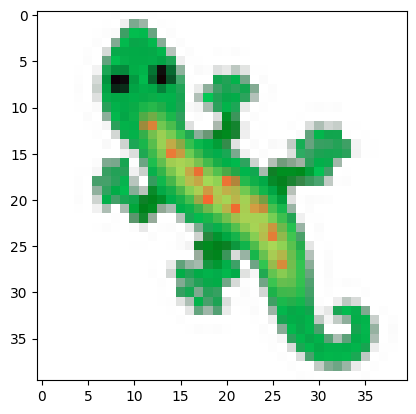

In [ ]:
plt.imshow(target_img)
plt.show()

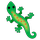

In [ ]:
imshow(target_img)

In [ ]:
# Define Model

class CAModel(nn.Module):
  def __init__(self, hidden_size=128, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    # Construct learnable perception filters - instead of building a 48 long vector though, directly blow up convolution to hidden size
    # perceive_conv = nn.Conv2d(in_channels=self.channel_n, out_channels=hidden_size, kernel_size=3, padding='same', groups=self.channel_n)
    
    # Equivariant Perception
    r2_act = gspaces.Rot2dOnR2(N=4)
    in_type = e2cnn.nn.FieldType(r2_act, CHANNEL_N*[r2_act.trivial_repr])
    out_type = e2cnn.nn.FieldType(r2_act, 48*[r2_act.regular_repr]) # 32*4=128 is hidden size
    # out_type = e2cnn.nn.FieldType(r2_act, 32*[r2_act.trivial_repr]) # 32*4=128 is hidden size
    equivariant_perception = e2cnn.nn.R2Conv(in_type, out_type, kernel_size=3, \
                               padding=(1,1), groups=CHANNEL_N)
    
    self.gpool = e2cnn.nn.GroupPooling(out_type)

    conv1 = nn.Conv2d(in_channels=48, out_channels=hidden_size, kernel_size=1)
    conv2 = nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    
    # Apply "do-nothing" initial behavior
    # torch.nn.init.xavier_uniform_(conv1.weight) # default to how tensorflow initializes the weights
    # torch.nn.init.zeros_(perceive_conv.bias)
    torch.nn.init.zeros_(conv2.weight)
    torch.nn.init.zeros_(conv1.bias)
    torch.nn.init.zeros_(conv2.bias)

    self.input_type = in_type
    self.perceive = e2cnn.nn.SequentialModule(
        equivariant_perception,
        # e2cnn.nn.ReLU(out_type)
    )
    
    # self.perceive = nn.Sequential(
    #     perceive_conv,
    #     nn.ReLU(),
    # )

    self.dmodel = nn.Sequential(
        conv1,
        nn.ReLU(),
        conv2,
    )

  def forward(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    x = torch.permute(x, (0, 3, 1, 2)) # make it shape [batch_size, in_channels, H, W]
    pre_life_mask = get_living_mask(x)

    # Geometric version
    geometric_x = e2cnn.nn.GeometricTensor(x, self.input_type)
    y = self.perceive(geometric_x)
    
    # Pool over the group
    y = self.gpool(y).tensor
    
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = torch.rand(x[:, :1, :, :].shape, device=device, dtype=torch.float32) <= fire_rate
    x = x + dx * update_mask

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    result = x * life_mask
    return torch.permute(result, (0, 2, 3, 1)) # send it back [batch_size, H, W, in_channels]

print(CAModel().perceive)
print(CAModel().dmodel)

SequentialModule(
  (0): R2Conv([4-Rotations: {irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0, irrep_0}], [4-Rotations: {regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular, regular}], kernel_size=3, stride=1, padding=(1, 1), groups=16)
)
Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)


/usr/local/lib/python3.10/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


shape of permuted seed: torch.Size([16, 72, 72])


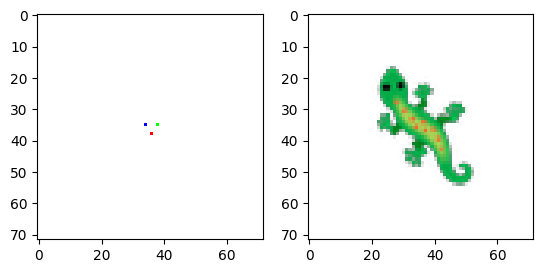

In [ ]:
# I love chatGPT
def get_circle_points(a, b, radius, num_points=3):
    """Returns three non-collinear points on a circle, centered
        at (a, b) with radius `radius`."""
    points = []
    for i in range(num_points):
        angle = 2 * math.pi * i / num_points
        x = a + radius * math.cos(angle)
        y = b + radius * math.sin(angle)
        points.append((int(round(x)), int(round(y))))
    return points

def make_seed(target_img, radius=None, rot=0, p=TARGET_PADDING, device=device, print_seed=True):
    """Makes an asymmetric seed with three non-collinear points.
        If radius is None, seeds a single pixel.
        `rot` is an int in [1,2,3,4], representing 90 degree
        rotations to the left."""
    target_img = torch.tensor(target_img)
    pad_target = torch.nn.functional.pad(target_img, (0, 0, p, p, p, p))
    h, w = pad_target.shape[:2] # get height and width of padded target image
    x, y = h//2, w//2 # get coordinates of center pixel
    seed = torch.zeros(h, w, CHANNEL_N, dtype=torch.float32)
    if radius is None:
        seed[x, y, 3:] = 1.0    
        return seed

    # Rotate the points
    points = get_circle_points(x, y, radius)
    points = [points[(i+rot) % len(points)] for i in range(len(points))]

    # Seed the points
    for color_channel_i, point in enumerate(points):
        seed[point[0], point[1], 3:] = 1.0  # set auxiliary channels
        seed[point[0], point[1], color_channel_i] = 1.0  # set color channel
        
    if print_seed:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        permuted_seed = seed.permute(-1, 0, 1)
        print(f'shape of permuted seed: {permuted_seed.shape}')
        ax1.imshow(seed[..., :4])
        ax2.imshow(pad_target)
        # ax2.imshow(permuted_seed[:4, ...])
        fig.show()
        
    return seed.to(device), pad_target.to(device)
        
seed, pad_target = make_seed(target_img, radius=2)

In [ ]:
h, w = pad_target.shape[:2] # get height and width of padded target image
x, y = h//2, w//2 # get coordinates of center pixel

points = get_circle_points(x, y, 2)
print(points)
points = [points[(i+2) % len(points)] for i in range(len(points))]
print(points)

[(38, 36), (35, 38), (35, 34)]
[(35, 34), (38, 36), (35, 38)]


In [ ]:
def plot_tensor(tensor):
    """plt.imshow a geometric tensor"""
    # Convert to PyTorch tensor
    try:
        tensor = tensor.tensor
    except AttributeError:
        plt.imshow(tensor.detach().cpu()[..., :4])
        plt.show() 
        return
    
    # Reshape to matplotlib convention
    tensor = tensor.detach().cpu() # detach tensor
    if len(tensor.shape) == 3:
        permuted_tensor = tensor.permute(1, 2, 0)
    elif len(tensor.shape) == 4:
        permuted_tensor = tensor.permute(0, 2, 3, 1)[0, ...]
    else:
        raise ValueError("geometric_tensor is not 3 or 4 dimensions")
    plt.imshow(permuted_tensor[..., :4])
    plt.show()

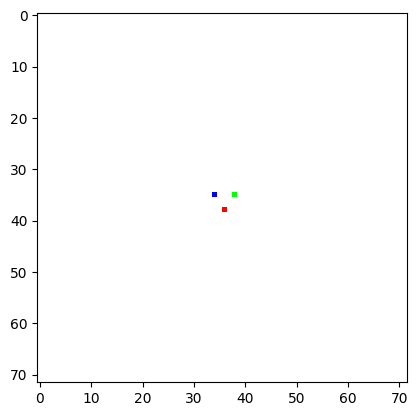

In [ ]:
seed.shape
plot_tensor(seed)

In [ ]:
# Training Sequence

class Train:
  def __init__(self, ca_model, target, loss_log=[], lr=2e-3):
    self.ca = ca_model
    self.target = einops.repeat(target, '... -> b ...', b=BATCH_SIZE)
    self.lr = lr
    # Initialize optimizer with lr scheduler
    self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr, weight_decay=1e-8)
    # self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr)
    # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optim, step_size=2000, gamma=0.1)
    # Use library MSELoss
    self.loss_f = nn.MSELoss()

    # Log the training progress
    self.loss_log = loss_log

  def train(self, x0, n_steps=1001):
    "Just support Growing mode for now"

    for i in range(n_steps+1):

      # Run through a single training step of the model
      x, loss = self._train_step(x0)
      self.loss_log.append(loss)
      # print(f'loss log is {self.loss_log}')

      # Printing
      if i % 100 == 0:
        clear_output()

        # visualize batch
        visualize_batch(x0.detach().cpu(), x.detach().cpu(), i)
        
        # plot loss
        plot_loss(self.loss_log)
        # export model

      print('\r step: %d, log10(loss): %.3f'%(len(self.loss_log), np.log10(loss)), end='')

    return self.loss_log
    
  def _train_step(self, x):
    """Perform the update step some random number of times"""
    iter_n = np.random.randint(64, 97, dtype=np.int32)
    # Clear previous gradients accumulated on parameters
    self.optim.zero_grad()
    for _ in range(iter_n):
      # Forward pass of model
      x = self.ca(x)

    # Compute loss
    loss = self.loss_f(to_rgba(x), self.target)
    # loss = self._loss_f(x, self.target).mean()

    # Compute gradients
    loss.backward()
    
    # Update parameters
    self.optim.step()
    
    # Update learning rate step
    # self.scheduler.step()

    return x, loss.item()

  def _loss_f(self, output, target):
    return torch.square(to_rgba(output) - target).mean(dim=(-2, -3, -1))


batch (before/after):


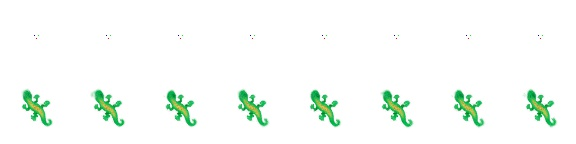

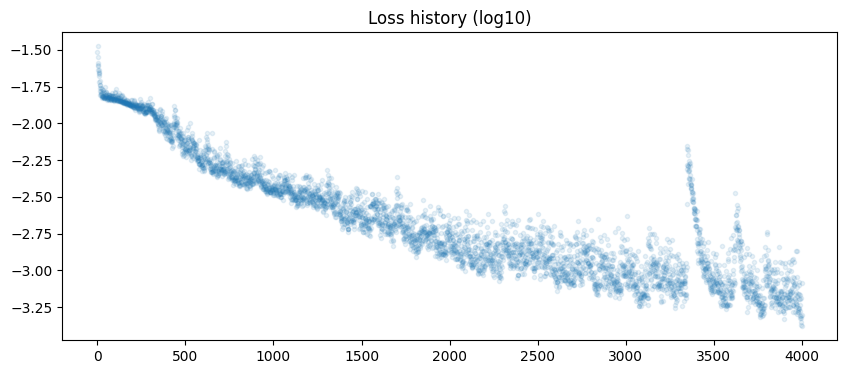

 step: 4002, log10(loss): -3.373CPU times: user 15min 57s, sys: 1min 34s, total: 17min 32s
Wall time: 17min 14s


In [ ]:
%%time

ca = CAModel().to(device)
train = Train(ca, pad_target.to(device))

x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
loss_log = train.train(x0.to(device), n_steps=4001)

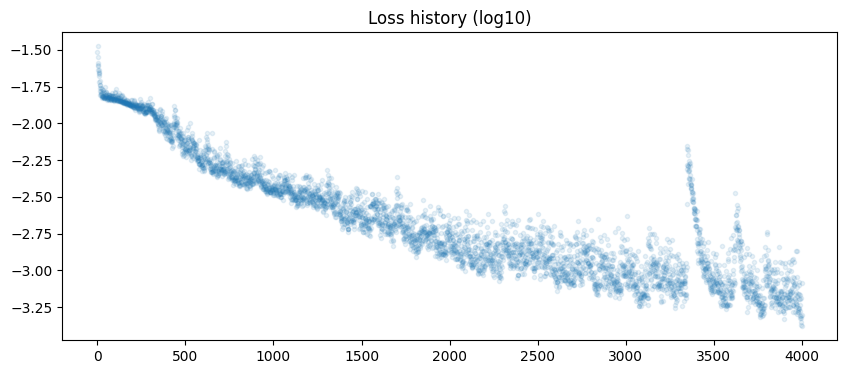

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(np.log10(loss_log[:4001]), '.', alpha=0.1)
plt.title('Loss history (log10)')

plt.savefig("equivariant_loss_log", format='svg')
plt.show()


In [ ]:
output = x0.clone()
for _ in range(90):
  output = ca(output)
output.shape

torch.Size([8, 72, 72, 16])

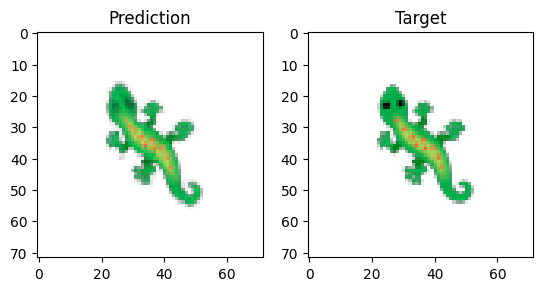

In [ ]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(output.detach().cpu()[0, ..., :4])
axs[1].imshow(pad_target.detach().cpu())

axs[0].set_title("Prediction")
axs[1].set_title("Target")

fig.savefig("equivariant_performance", format='svg')
fig.show()

In [ ]:
save_ca_model(ca, "equivariant_lizard_3")

Saved model equivariant_lizard_3 to disk


In [ ]:
x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
ca = load_ca_model(CAModel, "e2cnn_model_2_4001")

batch (before/after):


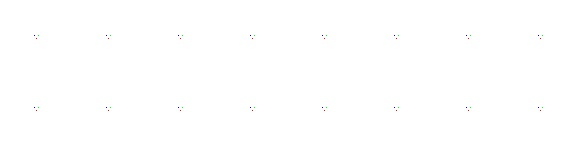

In [ ]:
visualize_batch(x0.detach().cpu(), x0.detach().cpu(), None)

shape of permuted seed: torch.Size([16, 72, 72])


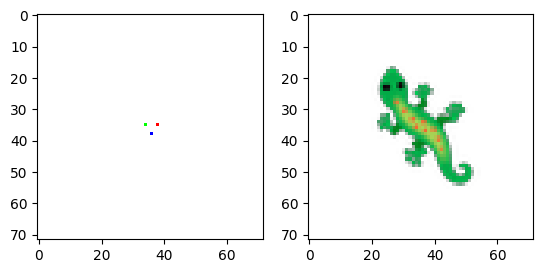

In [ ]:
rotated_seed, _ = make_seed(target_img, radius=2, rot=1)

In [ ]:
pad_target.shape

torch.Size([72, 72, 4])

In [ ]:
def simulate_model(model, init, n_steps, target=pad_target, name=None, device=torch.device('cuda')):
    """Runs the simulation for ca model `models` for n_steps, starting
        from initial condition `init`.
    """

    loss_f = nn.MSELoss()
    if len(target.shape) < 4:
      target = einops.repeat(target, '... -> b ...', b=init.shape[0])
    with torch.no_grad():
        x, model, target = init.to(device), model.to(device), target.to(device)
        for _ in tqdm.trange(n_steps):
            x = model(x)
        
        # If batch size is 1, use matplotlib's imshow
        if init.shape[0] == 1:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
            ax1.imshow(init.detach().cpu()[0, ..., :4])
            # ax1.set_title("Initial seed")
            ax1.set_axis_off()

            ax2.imshow(x.detach().cpu()[0, ..., :4])
            # ax2.set_title("Prediction")
            ax2.set_axis_off()

            ax3.imshow(target.detach().cpu()[0, ...])
            # ax3.set_title("Target")
            ax3.set_axis_off()

            fig.show()     
            
            # Save figure if name not None
            if name is not None:     
              fig.tight_layout()
              fig.savefig(name, format='svg')      
              print(f"Saved figure as {name}.") 

            # Calculate loss
            loss = loss_f(to_rgba(x), target).detach().cpu()
        else:
            # Display target to grow
            plt.imshow(target.cpu())
            plt.title("Target to grow")
            plt.axis('off')
            plt.show()          
            visualize_batch(init.detach().cpu(), x.detach().cpu(), n_steps)

            # Calculate loss
            loss = loss_f(to_rgba(x), target).detach().cpu()

            if name is not None:     
              plt.savefig(name, format='svg')      
              print(f"Saved figure as {name}.")             
            
        # Print loss
        print("Log10(loss) w.r.t. target is {:2f}".format(np.log10(loss)))

        return x.detach()
        # return loss

In [ ]:
def rotate(tensor, element):
  """Take a PyTorch tensor and apply an element transformation
    from the cyclic group C4, returning a PyTorch tensor again.
  """
  if len(tensor.shape) < 4:
    tensor = tensor.unsqueeze(0)
  n_channels = tensor.shape[-1] # extract the number of channels
  r2_act = gspaces.Rot2dOnR2(N=4)
  in_type = e2cnn.nn.FieldType(r2_act, n_channels*[r2_act.trivial_repr])
  geometric_tensor = e2cnn.nn.GeometricTensor(tensor.permute(0, -1, 1, 2), in_type)
  return geometric_tensor.transform(element).tensor.permute(0, 2, 3, 1)

100%|██████████| 90/90 [00:00<00:00, 1008.95it/s]


Log10(loss) w.r.t. target is -3.407109


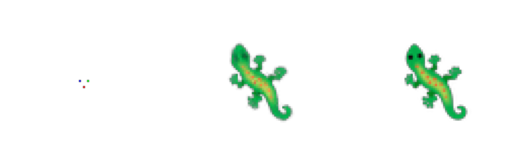

In [ ]:
element = 0
_ = simulate_model(ca, rotate(seed, element), n_steps=90, target=rotate(pad_target, element), device=device)

In [ ]:
x0.shape

torch.Size([8, 72, 72, 16])

/usr/local/lib/python3.10/dist-packages/e2cnn/nn/field_type.py:235: UserWarning: The input tensor is on GPU. The `FieldType.transform()` operation is based on `numpy` and, therefore, must temporarily move the tensor on CPU. This can cause performance issues.
  warnings.warn('The input tensor is on GPU. The `FieldType.transform()` operation is based on `numpy` and,'


torch.Size([1, 16, 72, 72])
torch.Size([1, 72, 72, 16])


100%|██████████| 90/90 [00:00<00:00, 1011.34it/s]


Saved figure as fig1.
Log10(loss) w.r.t. target is -3.355402


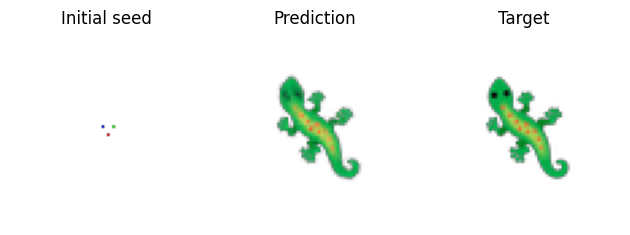

In [ ]:
# Copy from inside model
r2_act = gspaces.Rot2dOnR2(N=4)
in_type = e2cnn.nn.FieldType(r2_act, CHANNEL_N*[r2_act.trivial_repr])
input_x = seed.unsqueeze(0)
geometric_x0 = e2cnn.nn.GeometricTensor(input_x.permute(0, -1, 1, 2), in_type)
print(geometric_x0.tensor.shape)

rotated_seed = geometric_x0.transform(0).tensor.permute(0, 2, 3, 1)
print(rotated_seed.shape)
_ = simulate_model(ca, rotated_seed, n_steps=90, name='fig1', device=device)

100%|██████████| 90/90 [00:00<00:00, 986.67it/s]


Log10(loss) w.r.t. target is -3.428806


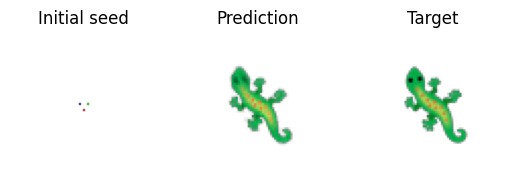

In [ ]:
element = 0
_ = simulate_model(ca, rotate(seed, element), n_steps=90, target=rotate(pad_target, element), device=device)

In [ ]:
# Define Model

class CAModelOld(nn.Module):
  def __init__(self, hidden_size=128, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    # Construct learnable perception filters - instead of building a 48 long vector though, directly blow up convolution to hidden size
    perceive_conv = nn.Conv2d(in_channels=self.channel_n, out_channels=48, kernel_size=3, padding='same', groups=self.channel_n)

    conv1 = nn.Conv2d(in_channels=48, out_channels=hidden_size, kernel_size=1)
    conv2 = nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    
    # Apply "do-nothing" initial behavior
    torch.nn.init.zeros_(perceive_conv.bias) # zero out the bias in the PyTorch case
    torch.nn.init.zeros_(conv2.weight)
    torch.nn.init.zeros_(conv1.bias)
    torch.nn.init.zeros_(conv2.bias)
    
    self.perceive = nn.Sequential(
        perceive_conv,
        nn.ReLU(),
    )

    self.dmodel = nn.Sequential(
        conv1,
        nn.ReLU(),
        conv2,
    )

  def forward(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    x = torch.permute(x, (0, 3, 1, 2)) # make it shape [batch_size, in_channels, H, W]
    pre_life_mask = get_living_mask(x)
    y = self.perceive(x)
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = torch.rand(x[:, :1, :, :].shape, device=device, dtype=torch.float32) <= fire_rate
    x = x + dx * update_mask
    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    result = x * life_mask
    return torch.permute(result, (0, 2, 3, 1)) # send it back [batch_size, H, W, in_channels]

print(CAModelOld().perceive)
print(CAModelOld().dmodel)

Sequential(
  (0): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=16)
  (1): ReLU()
)
Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)


In [ ]:
len(loss_log)

4142

batch (before/after):


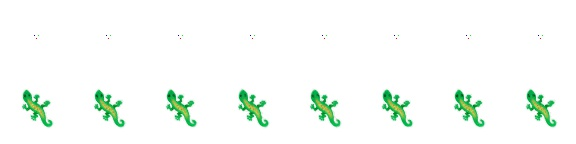

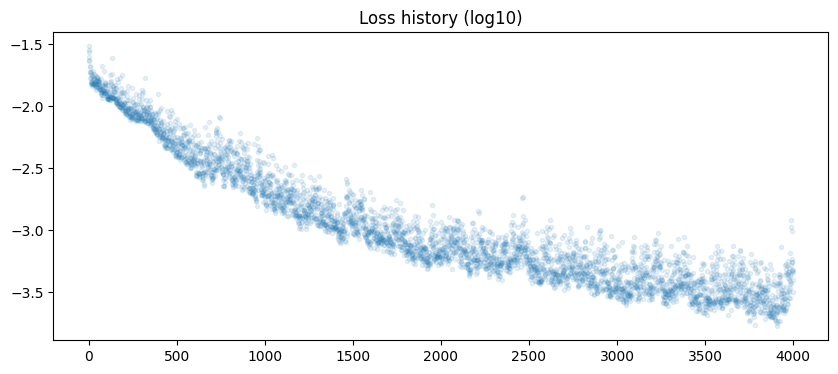

 step: 4002, log10(loss): -3.423CPU times: user 7min 22s, sys: 13.3 s, total: 7min 35s
Wall time: 7min 21s


In [ ]:
%%time

# Train model on lizard without equivariance
ca_old = CAModelOld().to(device)
train_old = Train(ca_old, pad_target.to(device))

x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
loss_log_old = train_old.train(x0.to(device), n_steps=4001)

In [ ]:
x0.shape

torch.Size([8, 72, 72, 16])

100%|██████████| 100/100 [00:00<00:00, 1891.61it/s]


Log10(loss) w.r.t. target is -1.517697


100%|██████████| 100/100 [00:00<00:00, 1048.01it/s]


Log10(loss) w.r.t. target is -3.261908


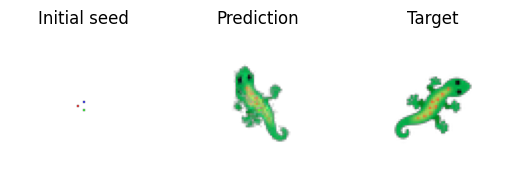

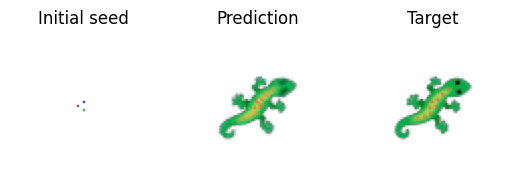

In [ ]:
element = 3
_ = simulate_model(ca_old, rotate(seed, element), n_steps=100, target=rotate(pad_target, element), device=device)
_ = simulate_model(ca, rotate(seed, element), n_steps=100, target=rotate(pad_target, element), device=device)

100%|██████████| 90/90 [00:00<00:00, 912.73it/s]


Log10(loss) w.r.t. target is -3.229390


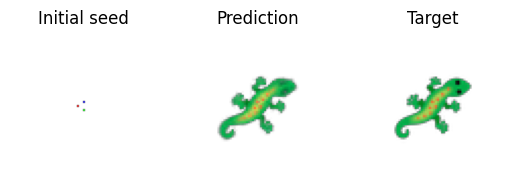

In [ ]:
element = 3
_ = simulate_model(ca, rotate(seed, element), n_steps=90, target=rotate(pad_target, element), device=device)

/usr/local/lib/python3.10/dist-packages/e2cnn/nn/field_type.py:235: UserWarning: The input tensor is on GPU. The `FieldType.transform()` operation is based on `numpy` and, therefore, must temporarily move the tensor on CPU. This can cause performance issues.
  warnings.warn('The input tensor is on GPU. The `FieldType.transform()` operation is based on `numpy` and,'
100%|██████████| 50/50 [00:00<00:00, 989.21it/s]


Log10(loss) w.r.t. target is -2.255498


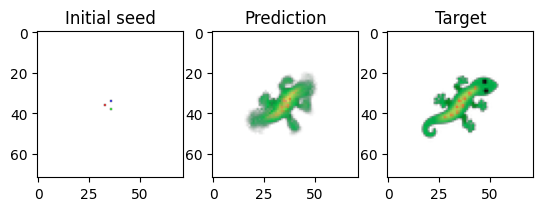

In [ ]:
element = 3
x_intermediate = simulate_model(ca, rotate(seed, element), n_steps=50, target=rotate(pad_target, element), device=device)

In [ ]:
def generate_all_figs(model1, model2, seed, pad_target, n_steps, name=None, device=torch.device('cuda')):
    """Generate all figures from experiment for presentation.
    """

    loss_f = nn.MSELoss()
    if len(pad_target.shape) < 4:
      target = einops.repeat(pad_target, '... -> b ...', b=seed.shape[0])

    # Loop through all elements:
    elements = [0, 1, 2, 3]

    # Prepare figure
    fig, axs = plt.subplots(4, 4, figsize=(10,4))
    axs[0][0].set_title("Initial seed")
    axs[0][1].set_title("Original Prediction")
    axs[0][2].set_title("Equivariant Prediction")
    axs[0][3].set_title("Target")

    with torch.no_grad():

        for e in range(4):

          # Apply group transformation
          init, target = rotate(seed, e), rotate(pad_target, e)

          # Move to device
          x1, model1, model2, target = init.to(device), model1.to(device), model2.to(device), target.to(device)
          x2 = x1.clone()

          # Run the model for `n_steps`
          for _ in tqdm.trange(n_steps):
              x1 = model1(x1)
              x2 = model2(x2)

          # Plot the axes
          axs[e][0].imshow(init.detach().cpu()[0, ..., :4])
          axs[e][0].set_axis_off()

          axs[e][1].imshow(x1.detach().cpu()[0, ..., :4])
          axs[e][1].set_axis_off()

          axs[e][2].imshow(x2.detach().cpu()[0, ..., :4])
          axs[e][2].set_axis_off()          

          axs[e][3].imshow(target.detach().cpu()[0, ...])
          axs[e][3].set_axis_off()    
          
        # Save figure if name not None
        if name is not None:     
          fig.tight_layout()
          fig.savefig(name, format='svg')      
          print(f"Saved figure as {name}.") 

        fig.show() 
        

100%|██████████| 90/90 [00:00<00:00, 667.59it/s]


Saved figure as experiments.


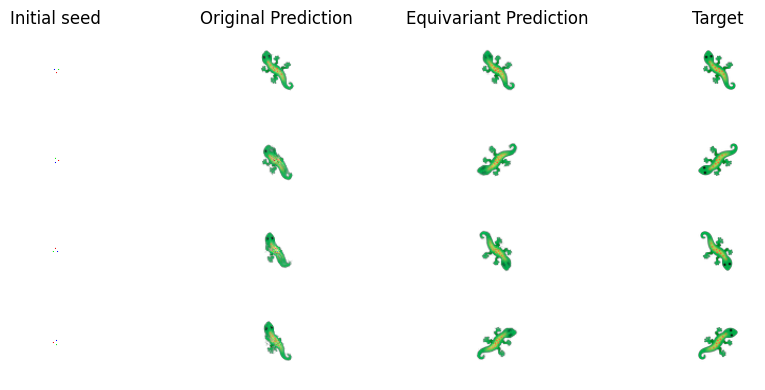

In [ ]:
generate_all_figs(ca_old, ca, seed, pad_target, 90, name="experiments")

torch.Size([1, 72, 72, 16])
torch.Size([1, 72, 72, 16])


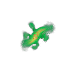

In [ ]:
print(x_intermediate.shape)
x_intermediate_rotated = rotate(x_intermediate.detach().cpu(), 2)
print(x_intermediate_rotated.shape)
imshow(x_intermediate_rotated[0, ..., :4])

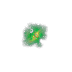

In [ ]:
imshow(x_intermediate.detach().cpu()[0, ..., :4])

100%|██████████| 40/40 [00:00<00:00, 998.77it/s]


Log10(loss) w.r.t. target is -3.424271


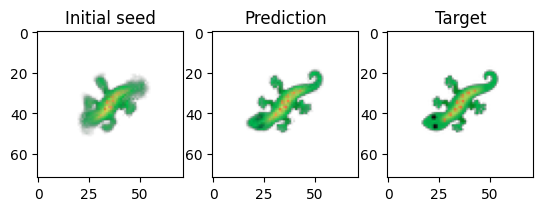

In [ ]:
element = 2
x_final = simulate_model(ca, rotate(x_intermediate.detach().cpu(), element), n_steps=40, target=rotate(pad_target, 1), device=device)

In [ ]:
reg_seed = make_seed(target_img)
print(reg_seed.shape)

torch.Size([72, 72, 16])


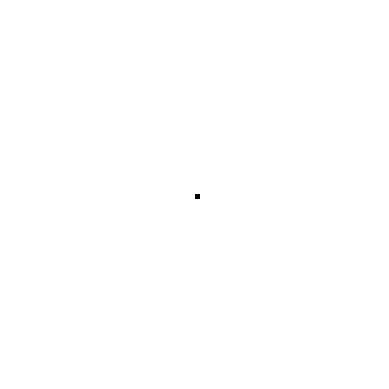

In [ ]:
plt.imshow(to_rgba(reg_seed))
plt.axis('off')
plt.savefig("single_seed", format='svg')
plt.show()

torch.Size([72, 72, 16])


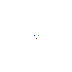

In [ ]:
s = seed.detach().cpu()
print(s.shape)
imshow(to_rgba(s))

100%|██████████| 60/60 [00:00<00:00, 1775.55it/s]


Saved figure as orig_sim.
Log10(loss) w.r.t. target is -2.984238


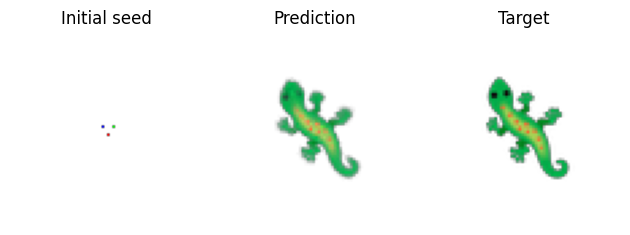

In [ ]:
_ = simulate_model(ca_old, s.unsqueeze(0), 60, name='orig_sim')

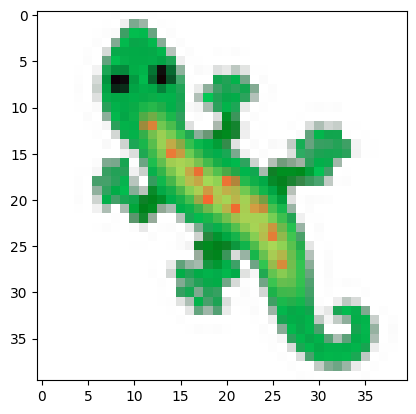

In [ ]:
plt.imshow(target_img)

In [ ]:
def simulate_model1(model, init, n_steps, target=pad_target, name=None, device=torch.device('cuda')):
    """Runs the simulation for ca model `models` for n_steps, starting
        from initial condition `init`.
    """

    loss_f = nn.MSELoss()
    if len(target.shape) < 4:
      target = einops.repeat(target, '... -> b ...', b=init.shape[0])
    with torch.no_grad():
        x, model, target = init.to(device), model.to(device), target.to(device)
        for _ in tqdm.trange(n_steps):
            x = model(x)
        
        # If batch size is 1, use matplotlib's imshow
        if init.shape[0] == 1:
            # fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
            # ax1.imshow(init.detach().cpu()[0, ..., :4])
            # ax1.set_title("Initial seed")
            # ax1.set_axis_off()

            # ax2.imshow(x.detach().cpu()[0, ..., :4])
            # ax2.set_title("Prediction")
            # ax2.set_axis_off()

            # ax3.imshow(target.detach().cpu()[0, ...])
            # ax3.set_title("Target")
            # ax3.set_axis_off()

            # fig.show()     
            
            plt.imshow(x.detach().cpu()[0, ..., :4])
            # plt.imshow(target.detach().cpu()[0, ...])
            plt.axis('off')

            # Save figure if name not None
            if name is not None:     
              plt.savefig(name, format='svg')

            plt.show()

            # Calculate loss
            loss = loss_f(to_rgba(x), target).detach().cpu()
        else:
            # Display target to grow
            plt.imshow(target.cpu())
            plt.title("Target to grow")
            plt.axis('off')
            plt.show()          
            visualize_batch(init.detach().cpu(), x.detach().cpu(), n_steps)

            # Calculate loss
            loss = loss_f(to_rgba(x), target).detach().cpu()

            if name is not None:     
              plt.savefig(name, format='svg')      
              print(f"Saved figure as {name}.")             
            
        # Print loss
        print("Log10(loss) w.r.t. target is {:2f}".format(np.log10(loss)))

        return x.detach()
        # return loss

100%|██████████| 45/45 [00:00<00:00, 1677.32it/s]


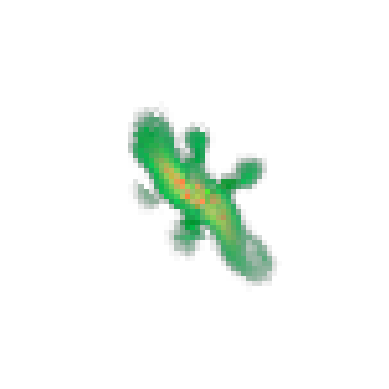

Log10(loss) w.r.t. target is -2.269440


In [ ]:
_ = simulate_model1(ca_old, s.unsqueeze(0), 45, name='input_to_model')